# Introduction
This Notebook provides an initial introduction to useful signal processing concepts common in HCI and ubiquitous computing. Interestingly, this stuff is crucially important but often skipped over in technical HCI/ubicomp papers with a disproportionate focus on the machine learning model in comparison to signal processing (e.g., the DSP filters used, etc.)

## Resources
- Allen B. Downey, *Think DSP: Digital Signal Processing in Python* [[website](http://greenteapress.com/wp/think-dsp/)] [[pdf](http://greenteapress.com/thinkdsp/thinkdsp.pdf)] [[github](http://greenteapress.com/wp/think-dsp/)]
- Allen B. Downey, *Basic Signal Processing in Python*, [YouTube video](https://youtu.be/0ALKGR0I5MA)

## Table of Contents
- [Basic Waves](#Basic-Waves)
- [Signal Comparisons](#Signal-Comparisons)
- [Noise and Smoothing](#Noise-and-Smoothing)
- [Fast Fourier Transforms (FFT)](#FFT)

## JonTODO: Future
In the future, consider adding:
- Convolution
- Wavelets?

In [1]:
#useful imports
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
import IPython.display as ipd # for playing sound https://ipython.org/ipython-doc/2/api/generated/IPython.lib.display.html#IPython.lib.display.Audio
import matplotlib as mpl


In [2]:
# Helper functions

def plot_signal_to_axes(ax, s, sampling_rate, title=None, signal_label=None, marker=None):
    '''Plots a sine wave s with the given sampling rate
    
    Parameters:
    ax: matplot axis to do the plotting
    s: numpy array
    sampling_rate: sampling rate of s
    title: chart title
    signal_label: the label of the signal
    '''
    ax.plot(s, label=signal_label, marker=marker)
    ax.set(xlabel="samples")
    
    if signal_label is not None:
        ax.legend()

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.2)
    
    ax.grid()

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("time (secs)")
    ax_ticks = ax.get_xticks()[1:-1]
    ax2_tick_labels = ax.get_xticks()[1:-1] / sampling_rate
    ax2_tick_labels = ['{:.2f}s'.format(x) for x in ax2_tick_labels]
    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)
    
def plot_multiple_freq(freqs, signal_combined, map_freq_to_signal, sampling_rate):
    n_rows = len(freqs) + 1 # one for each freq + combined on top
    n_cols = 1
    height_per_row = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * height_per_row))
    fig.subplots_adjust(hspace=0.7)

    plot_signal_to_axes(axes[0], signal_combined, sampling_rate, '{}Hz'.format(freqs).
             format(freq_of_note, total_time_in_secs, sampling_rate))
    axis_index = 1
    for freq in freqs:
        ax = axes[axis_index]
        signal_for_freq = map_freq_to_signal[freq]
        plot_signal_to_axes(ax, signal_for_freq[:1000], sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))
        axis_index += 1
        
def plot_aligned_signal_comparisons(a, b):
    '''Plots the best alignment between signals a and b'''
    corr_result_ab = signal.correlate(a,b)
    best_correlation_point = np.argmax(corr_result_ab)
    index_shift = len(a) - np.argmax(corr_result_ab)
    a_shifted = np.roll(a, index_shift - 1)

    euclid_distance_a_to_b = distance.euclidean(a, b)
    euclid_distance_ashifted_to_b = distance.euclidean(a_shifted, b)
    print("Best correlation point={}, euclidean distance a to b={}, euclidean distance a_shifted to b={}"
          .format(best_correlation_point, euclid_distance_a_to_b, euclid_distance_ashifted_to_b))

    fig, axes = plt.subplots(3, figsize=(12, 13))
    fig.subplots_adjust(hspace=0.3)

    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Graphs | Euclidean Distance From A to B = {}".format(euclid_distance_a_to_b))

    # Note that the correlation signal is the length of a + b but that's because
    # of how correlation works: it slides the two signals across each other to compute the correlation
    axes[1].plot(corr_result_ab, alpha=0.7)
    axes[1].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

    axes[2].plot(a_shifted, alpha=0.7, label="a_shifted", marker="o")
    axes[2].plot(b, alpha=0.7, label="b", marker="D")
    axes[2].legend()
    axes[2].set_title("Shifted Graph | Euclidean Distance From A_Shifted to B = {}".format(euclid_distance_ashifted_to_b))
    
def create_sine_wave(freq, sampling_rate, total_time_in_secs):
    '''Creates a sine wave with the given frequency, sampling rate, and length'''
    
    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    
    # Could also generate this signal by:
    # time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

    sine_wave = np.sin(2 * np.pi * freq * time)
    return sine_wave

def create_cos_wave(freq, sampling_rate, total_time_in_secs):
    '''Creates a cos wave with the given frequency, sampling rate, and length'''
    
    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    cos_wave = np.cos(2 * np.pi * freq * time)
    return cos_wave

def calc_zero_crossings(s, min_gap = None):
    '''Returns the number of zero crossings in the signal s
    
    This method is based on https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
    
    Parameters:
    s: the signal
    min_gap: the minimum gap (in samples) between zero crossings
    TODO:     
    - could have a mininum height after the zero crossing (within some window)
        to eliminate noise
    '''
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    last_zero_crossing_idx = None
    last_zero_cross_idx_saved = None
    for i in range(1, len(s)):
        next_pt = s[i]
        zero_crossing_idx = None
        
        # There are three cases to check for:
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            # if we're here, a zero crossing occurred
            zero_crossing_idx = i
          
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossing_idx = i
                
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossing_idx = i
        
        # now potentially add zero_crossing_idx to our list
        if zero_crossing_idx is not None:
            # potentially have a new zero crossing, check for other conditions
            if last_zero_cross_idx_saved is None or \
               last_zero_cross_idx_saved is not None and min_gap is None or \
               (min_gap is not None and (i - last_zero_cross_idx_saved) > min_gap):
                
                zero_crossings.append(zero_crossing_idx) # save the zero crossing point
                last_zero_cross_idx_saved = zero_crossing_idx
            
            last_zero_crossing_idx = zero_crossing_idx
            
        cur_pt = s[i]
    return zero_crossings

# Basic Waves

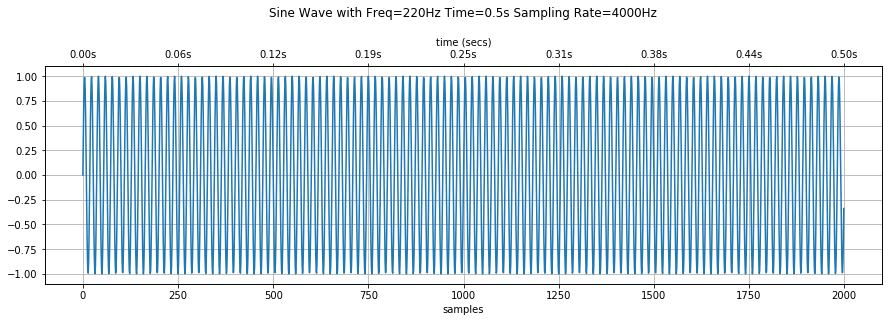

In [3]:
total_time_in_secs = 0.5 # length of waveform in time

# Common sound sampling rates are 8000, 11025, 22050, 44100
# See: https://manual.audacityteam.org/man/sample_rates.html
sampling_rate = 4000

# Try changing the frequency here. What happens?
# What's the lowest sound your speakers can produce (or you can hear?)
# What's the highest frequency sound?
# What happens if this freq exceeds the sampling_rate?
# Recall the nyquist frequency: the highest freq we can produce is less than 1/2 * sampling_rate
freq = 220 # in Hz; 

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

# Could also generate this signal by:
# time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

s = np.sin(2 * np.pi * freq * time)

fig, ax = plt.subplots(figsize=(15,4))
plot_signal_to_axes(ax, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))

ipd.Audio(s, rate=sampling_rate) # load a NumPy array

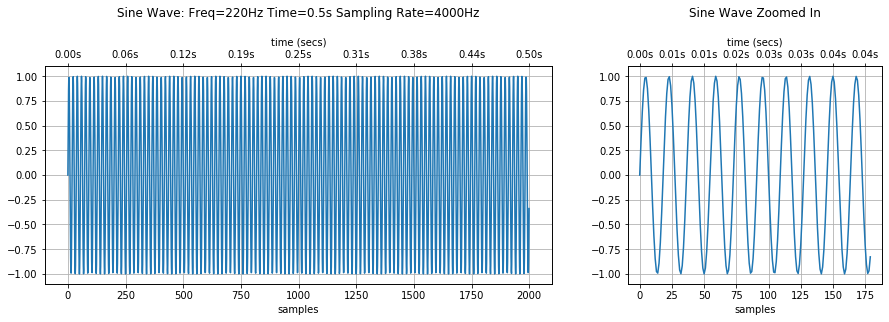

In [4]:
# Show the full waveform next to a zoomed in view
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave: Freq={}Hz Time={}s Sampling Rate={}Hz'.
                    format(freq, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
num_periods_to_show = 10
plot_signal_to_axes(axes[1], s[0: int(sampling_rate/freq)*num_periods_to_show], 
                    sampling_rate, 'Sine Wave Zoomed In')
ipd.Audio(s, rate=sampling_rate) # load a NumPy array

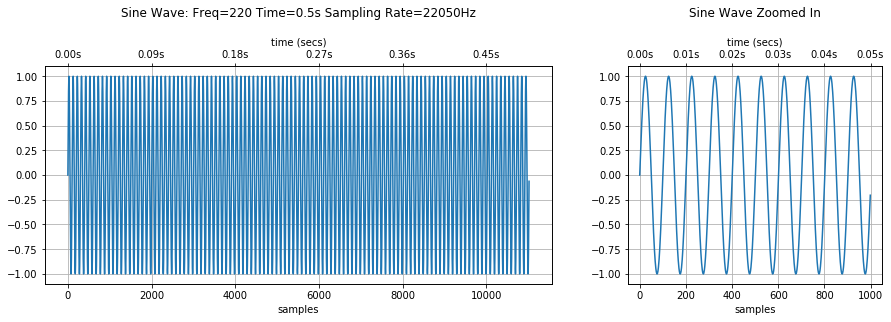

In [5]:
# Higher sampling rate. A high sampling rate will allow us to capture a higher
# fidelity representation of the signal (so will pickup things that change more quickly)
# In this case, with a simple sine wave form of 220Hz, the sampling rate doesn't matter
sampling_rate = 22050

time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.sin(2 * np.pi * freq * time)

fig, axes = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave: Freq={} Time={}s Sampling Rate={}Hz'.
                    format(freq, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
num_periods_to_show = 10
plot_signal_to_axes(axes[1], s[0: int(sampling_rate/freq)*num_periods_to_show], 
                    sampling_rate, 'Sine Wave Zoomed In')
ipd.Audio(s, rate=sampling_rate) # load a NumPy array

# Signal Comparisons

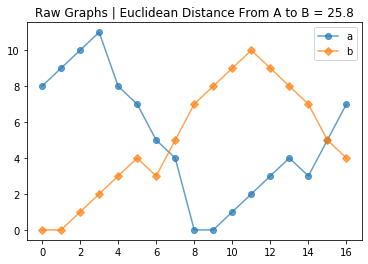

In [6]:
# Use Euclidean distance to compare two signals
from scipy import signal
from scipy.spatial import distance

a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots()

axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")
axes.legend()
axes.set_title("Raw Graphs | Euclidean Distance From A to B = {:0.1f}".format(euclid_distance_a_to_b))
print()

len(a): 17 np.argmax(corr_result_ab): 8 index_shift: 9
Best correlation point=8, euclidean distance a to b=25.768197453450252, euclidean distance a_shifted to b=2.0



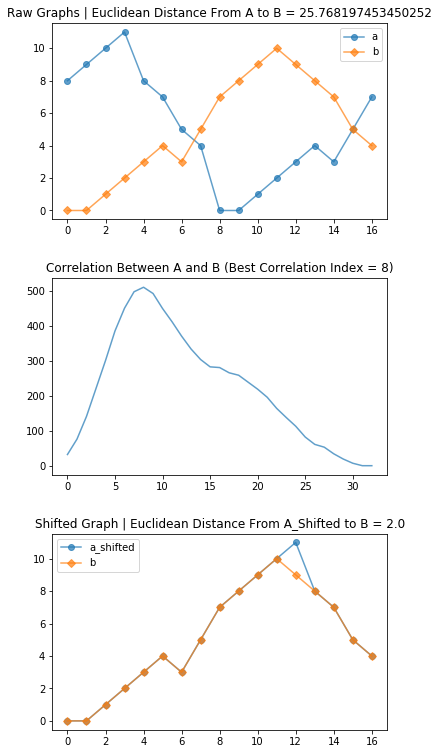

In [7]:
# Now let's use correlation to align the signals before comparison
corr_result_ab = signal.correlate(a,b)
best_correlation_point = np.argmax(corr_result_ab)
index_shift = len(a) - np.argmax(corr_result_ab)
print("len(a):", len(a), "np.argmax(corr_result_ab):", np.argmax(corr_result_ab), "index_shift:", index_shift)
a_shifted = np.roll(a, index_shift)

euclid_distance_a_to_b = distance.euclidean(a, b)
euclid_distance_ashifted_to_b = distance.euclidean(a_shifted, b)
print("Best correlation point={}, euclidean distance a to b={}, euclidean distance a_shifted to b={}"
      .format(best_correlation_point, euclid_distance_a_to_b, euclid_distance_ashifted_to_b))

fig, axes = plt.subplots(3, figsize=(6, 13))
fig.subplots_adjust(hspace=0.3)

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Raw Graphs | Euclidean Distance From A to B = {}".format(euclid_distance_a_to_b))

# Note that the correlation signal is the length of a + b but that's because
# of how correlation works: it slides the two signals across each other to compute the correlation
# You can change this by passing a different argument to signal.correlate (by default, it's 'full')
axes[1].plot(corr_result_ab, alpha=0.7)
axes[1].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

axes[2].plot(a_shifted, alpha=0.7, label="a_shifted", marker="o")
axes[2].plot(b, alpha=0.7, label="b", marker="D")
axes[2].legend()
axes[2].set_title("Shifted Graph | Euclidean Distance From A_Shifted to B = {}".format(euclid_distance_ashifted_to_b))
print()

Best correlation point=169, euclidean distance a to b=12.165525060596439, euclidean distance a_shifted to b=1.973205017723358


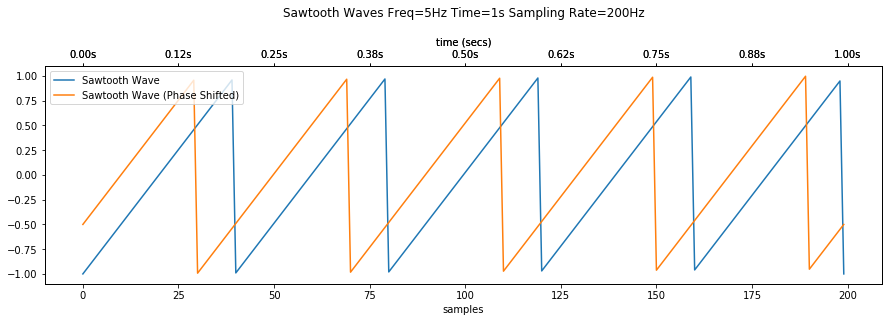

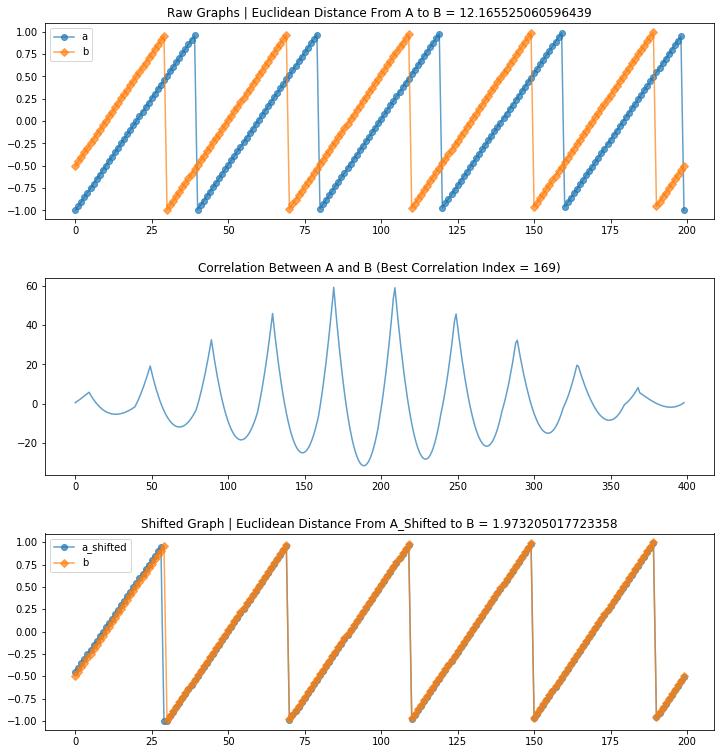

In [8]:
total_time_in_secs = 1
sampling_rate = 200
freq = 5

t = np.linspace(0, total_time_in_secs, sampling_rate)
sawtooth_a = signal.sawtooth(2 * np.pi * freq * t)
sawtooth_b = signal.sawtooth(2 * np.pi * freq * t + np.pi/2)
fig, ax = plt.subplots(figsize=(15,4))

title = 'Sawtooth Waves Freq={}Hz Time={}s Sampling Rate={}Hz'.\
          format(freq, total_time_in_secs, sampling_rate)
plot_signal_to_axes(ax, sawtooth_a, sampling_rate, title, "Sawtooth Wave")
plot_signal_to_axes(ax, sawtooth_b, sampling_rate, title, "Sawtooth Wave (Phase Shifted)")

plot_aligned_signal_comparisons(sawtooth_a, sawtooth_b)

Best correlation point=209, euclidean distance a to b=14.142135623730951, euclidean distance a_shifted to b=1.5211096026534148e-14


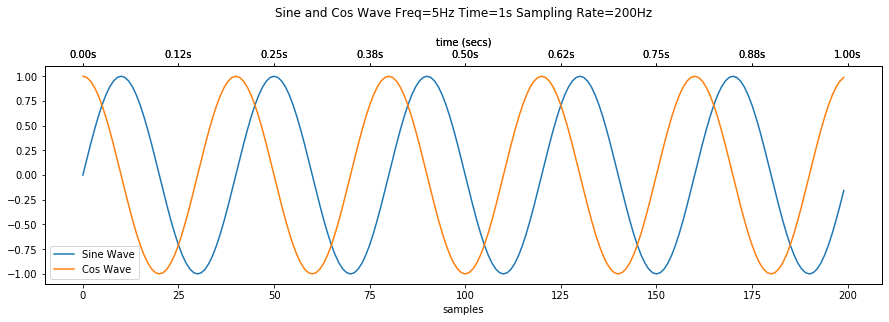

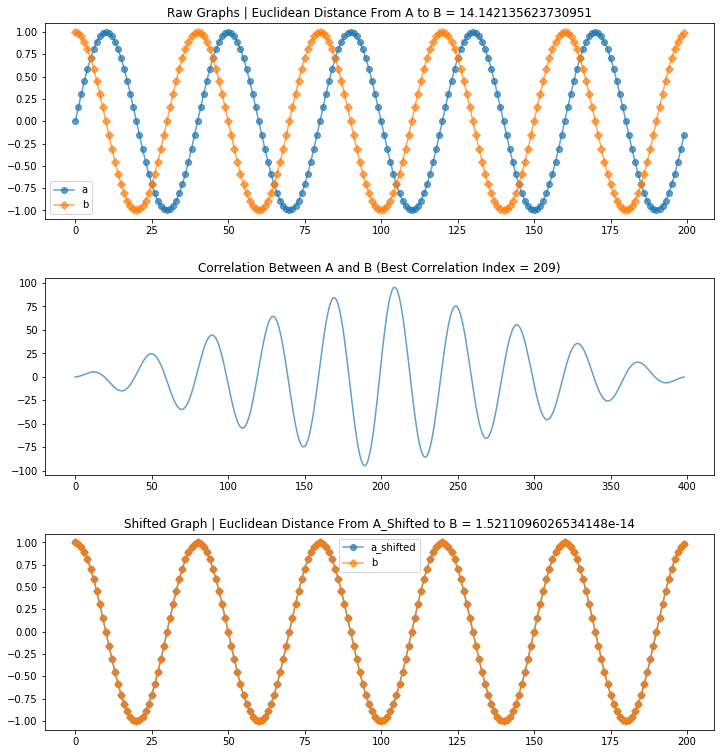

In [9]:
# Create and plot a simple sine and cos wave
total_time_in_secs = 1
sampling_rate = 200
freq = 5

sine_wave = create_sine_wave(freq, sampling_rate, total_time_in_secs)
cos_wave = create_cos_wave(freq, sampling_rate, total_time_in_secs)

fig, ax = plt.subplots(figsize=(15,4))
title = 'Sine and Cos Wave Freq={}Hz Time={}s Sampling Rate={}Hz'.\
          format(freq, total_time_in_secs, sampling_rate)

plot_signal_to_axes(ax, sine_wave, sampling_rate, title, "Sine Wave")
plot_signal_to_axes(ax, cos_wave, sampling_rate, title, "Cos Wave")

plot_aligned_signal_comparisons(sine_wave, cos_wave)

Cross-correlation expects two input arrays `x, y` of equal length. Matlab's [cross-correlation function](https://www.mathworks.com/help/matlab/ref/xcorr.html) (`xcorr`), for example, will automatically append zeros to the end of the shorter vector so it has the same length as the other. If `x, y` have two different lengths, you could:
- Extend the shorter array using padding (*e.g.,* pad with zeros, pad with mean)
- Ablate the longer array
- Use Dynamic Time Warping, which works with two input arrays of different lengths
- ...
See this [Stack Overflow post](https://stats.stackexchange.com/questions/211016/correlation-between-two-time-series-of-unequal-size).

In [10]:
# Test ablation.
from scipy import signal
from scipy.spatial import distance

def get_aligned_signals_ablate_manual(a, b):
    '''
    Aligns the signals and then equalizes their length (by trimming the longer signal)
    '''
    if len(a) > len(b):
        # b should always be larger than a
        a, b_cutoff = get_aligned_signals_ablate(b, a)
        return (b_cutoff, a)
    
    index = 0
    best_alignment_index = 0
    shortest_distance = None
    
    # iterates through each subsequence of b (of len(a)) looking
    # for the shortest euclidean distance
    while index + len(a) <= len(b):
        b_sample = b[index:index+len(a)]
        ab_distance = distance.euclidean(a, b_sample)
        
        if shortest_distance == None:
            shortest_distance = ab_distance
            
        if ab_distance < shortest_distance:
            best_alignment_index = index
            shortest_distance = ab_distance
        
        index += 1
    return (a, b[best_alignment_index : best_alignment_index + len(a)])
        
    
    

Text(0.5, 1.0, 'Aligned and Cutoff: a, b')

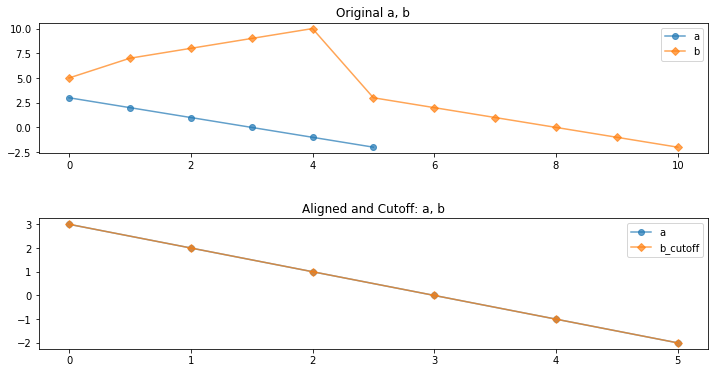

In [11]:
# a = np.array([5, 0, 0, 3, 2, 1, 0, -1, -2, 10, 11, 12, 13, 14])
# b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

a = np.array([3, 2, 1, 0, -1, -2])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])


fig, axes = plt.subplots(2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)
axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

a, b_cutoff = get_aligned_signals_ablate_manual(a, b)
axes[1].plot(a, alpha=0.7, label="a", marker="o")
axes[1].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[1].legend()
axes[1].set_title("Aligned and Cutoff: a, b")

# Additive Synthesis

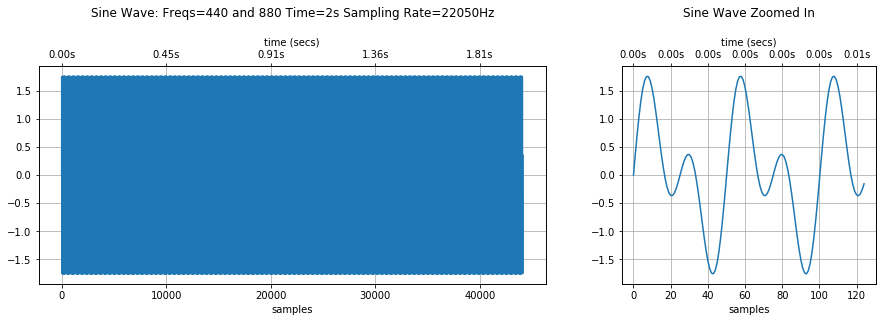

In [12]:
# Show additive nature of waves

total_time_in_secs = 2
sampling_rate = 22050

# Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
# rate to get each time_step)
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

# Could also generate this signal by:
# time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)
freq1 = 440
freq2 = 880
signal1 = np.sin(2 * np.pi * freq1 * time)
signal2 = np.sin(2 * np.pi * freq2 * time)
signal_combined = signal1 + signal2

n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
plot_signal_to_axes(axes[0], signal_combined, sampling_rate, 'Sine Wave: Freqs={} and {} Time={}s Sampling Rate={}Hz'.
                    format(freq1, freq2, total_time_in_secs, sampling_rate))

# show a zoomed in view of ~10 periods
plot_signal_to_axes(axes[1], signal_combined[0: int(sampling_rate/freq2)*5], sampling_rate, 'Sine Wave Zoomed In')

#zero_crossings = calc_zero_crossings(signal_combined[0: int(sampling_rate/freq2)*5])
# print(zero_crossings)
# for zero_index in zero_crossings:
#     axes[1].plot(zero_index, signal_combined[zero_index], marker='X', markersize=8, color="orange")

ipd.Audio(signal_combined, rate=sampling_rate) # load a NumPy array

# Noise and Smoothing

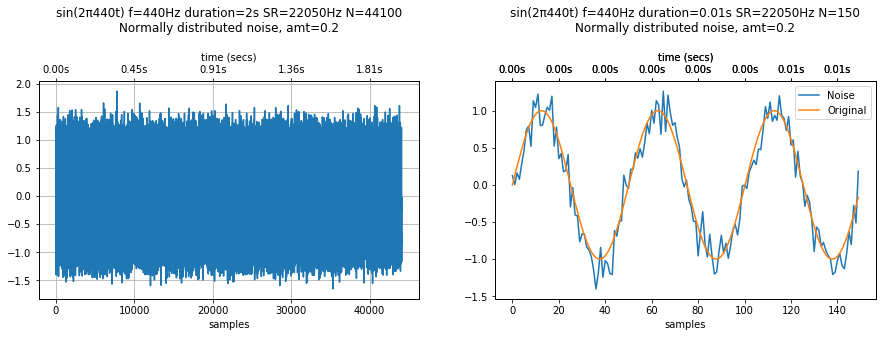

In [13]:
# Show addition of noise
total_time_in_secs = 2
freq = 440 # in Hz
sampling_rate = 22050

# Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
# rate to get each time_step)
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate

signal = np.sin(2 * np.pi * freq * time)

noise_amt = 0.2 # higher amount, higher noise
noise = np.random.normal(0,noise_amt,len(time))

signal_with_noise = signal + noise
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))

title = "sin(2π{}t) f={}Hz duration={}s SR={}Hz N={}\nNormally distributed noise, amt={}".\
        format(freq, freq, total_time_in_secs, sampling_rate, len(signal), noise_amt)
plot_signal_to_axes(axes[0], signal_with_noise, sampling_rate, title)

# show a zoomed in view
zoomed_in_samples = int(sampling_rate/freq)*3
zoomed_in_time = zoomed_in_samples/sampling_rate
title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally distributed noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
plot_signal_to_axes(axes[1], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label = "Noise")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, signal_label = "Original")
ipd.Audio(signal_with_noise, rate=sampling_rate) # load a NumPy array

## Mean Filter

Original signal length: 44100 Smoothed signal length:  44091


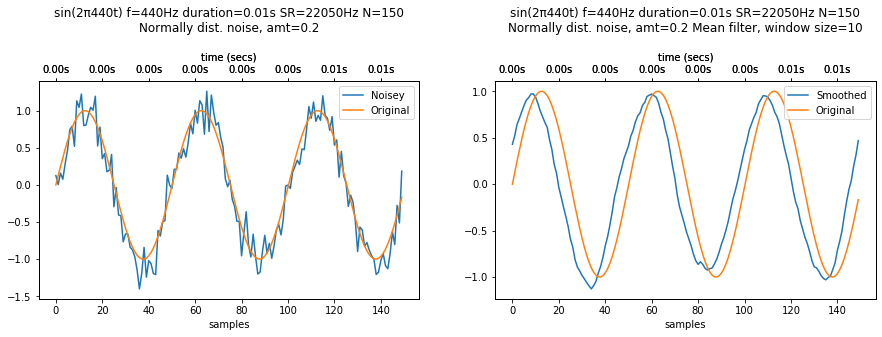

In [14]:
# shows how to apply a mean filter via convolution with a given window size
filter_window_size = 10
signal_smoothed_mean = np.convolve(signal_with_noise, np.ones((filter_window_size,))/filter_window_size, mode='valid') 

# convolutions return a slightly different sized array depending on the mode
# in this case, with the mode set to 'valid', the new length will be: len(signal_with_noise) - filter_window_size + 1
# to make them the same length, set mode to 'same'
# see: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html
print("Original signal length:", len(signal_with_noise), "Smoothed signal length: ", len(signal_smoothed_mean))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))

# zoom in
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)

title_zoomed_filtered = title_zoomed + " Mean filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_mean[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Original")
ipd.Audio(signal_smoothed_mean, rate=sampling_rate) 

Original signal length: 44100 Smoothed signal length:  44100


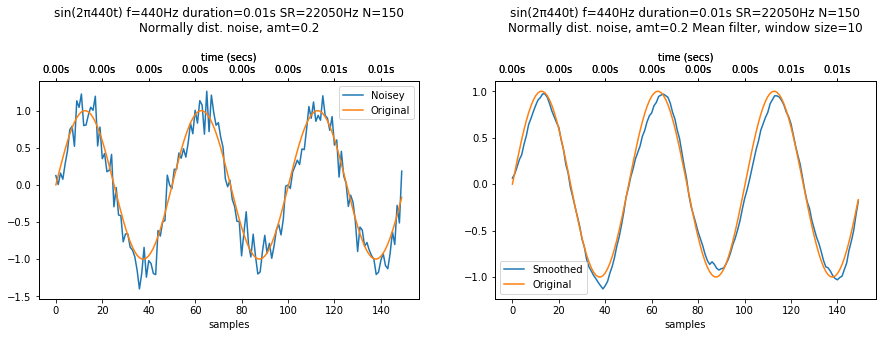

In [15]:
# now with mode='same'
filter_window_size = 10
signal_smoothed_mean = np.convolve(signal_with_noise, np.ones((filter_window_size,))/filter_window_size, mode='same') 
print("Original signal length:", len(signal_with_noise), "Smoothed signal length: ", len(signal_smoothed_mean))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))

# zoom in
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)

title_zoomed_filtered = title_zoomed + " Mean filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_mean[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Original")
ipd.Audio(signal_smoothed_mean, rate=sampling_rate) 

## Median Filter

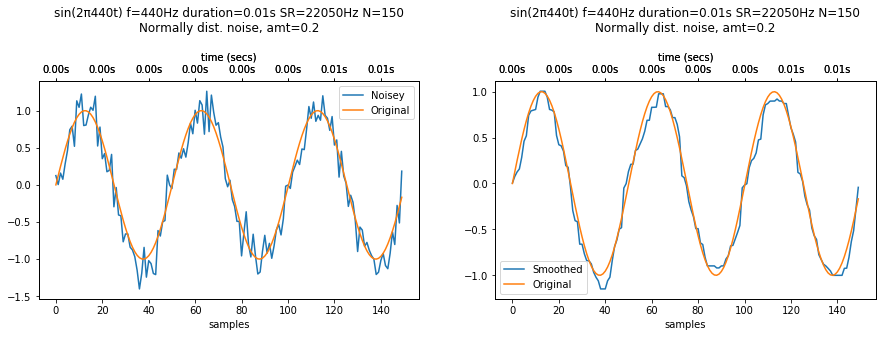

In [16]:
# Shows how to apply a median filter using scipy
filter_window_size = 11 # needs to be odd sized
signal_smoothed_median = sp.signal.medfilt(signal_with_noise, filter_window_size)

# plot zoomed in view
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
title_zoomed_filtered = title_zoomed + " Median filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_median[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

ipd.Audio(signal_smoothed_median, rate=sampling_rate) 

## Savgov Filter

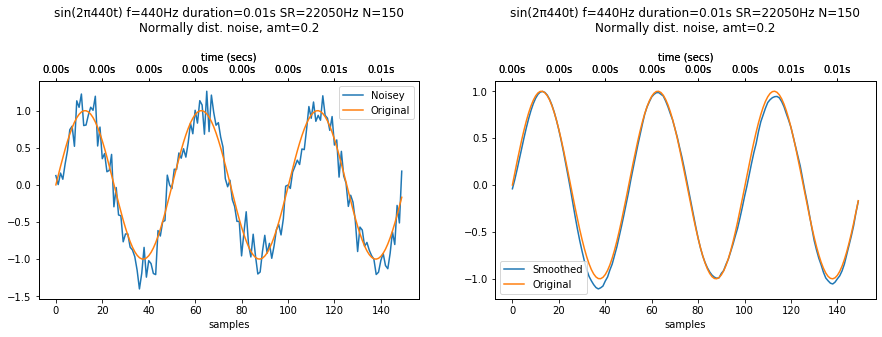

In [17]:
# from scipy.signal import savgol_filter
filter_window_size = 51
signal_smoothed_savgov = sp.signal.savgol_filter(signal_with_noise, filter_window_size, 5)

# plot zoomed in view
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4))
num_periods_to_show = 3
zoomed_in_samples = int(sampling_rate/freq)*num_periods_to_show
zoomed_in_time = zoomed_in_samples/sampling_rate

title_zoomed = "sin(2π{}t) f={}Hz duration={:.2f}s SR={}Hz N={}\nNormally dist. noise, amt={}".\
        format(freq, freq, zoomed_in_time, sampling_rate, zoomed_in_samples, noise_amt)
title_zoomed_filtered = title_zoomed + " Savgol filter, window size={}".format(filter_window_size)

plot_signal_to_axes(axes[0], signal_with_noise[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Noisey")
plot_signal_to_axes(axes[0], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

plot_signal_to_axes(axes[1], signal_smoothed_savgov[0: zoomed_in_samples], sampling_rate, title_zoomed_filtered, signal_label="Smoothed")
plot_signal_to_axes(axes[1], signal[0: zoomed_in_samples], sampling_rate, title_zoomed, signal_label="Original")

ipd.Audio(signal_smoothed_savgov, rate=sampling_rate) 

# FFT
A Fast Fourier Transform (FFT) samples a signal and extracts the frequency components. It is used to transform a signal from the time-domain to the frequency-domain.
![Time vs. Frequency view of signal](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "View of a signal in the time and frequency domain") 

For example, the signal below consists of a sum of cosine waves at 10, 20, 30, 40, and 50 Hz.
![FFT of an example signal](https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/FFT_of_Cosine_Summation_Function.png/800px-FFT_of_Cosine_Summation_Function.png)

## Resources
- One of the best resources I've found is this fantastic interactive guide by Jez Swanson: [An Interactive Introduction to Fourier Transforms](http://www.jezzamon.com/fourier/index.html)
- For a more mathematical take, try 3Blue1Brown's [But What is the Fourier Transform? A Visual Introduction](https://youtu.be/spUNpyF58BY) (and incidentally, 3Blue1Brown produces the best math videos on the Internet!).

### JonTODO: Resources to Look At
Below are a list of resources related to FFTs that I haven't had a chance to fully explore (yet)
- TODO, look at: Dashnow *et al.,* [Chapter 4: Frequency and the Fast Fourier Transform](https://learning.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html) from the book [Elegant Scipy](https://learning.oreilly.com/library/view/elegant-scipy/9781491922927/)

We have 1000 frequency bins of size 4.0Hz from 0.0 to 2000.0Hz
Freq with max intensity 220.0 Hz


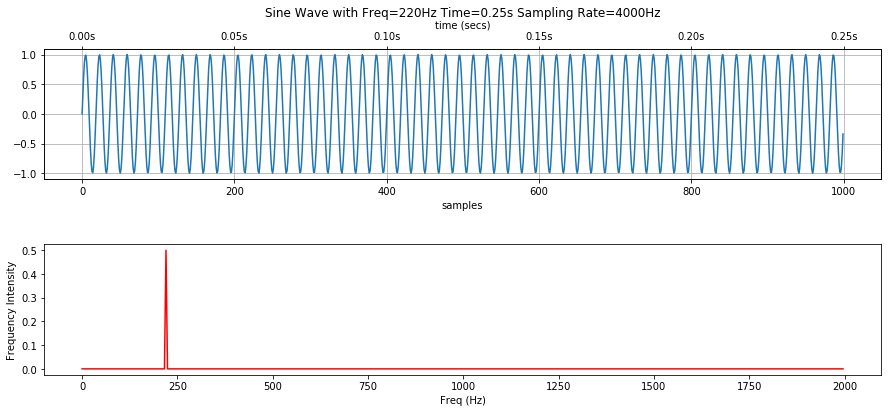

In [18]:
# Let's perform an FFT of a simple sine wave and plot the frequency plot
# Example based on https://plot.ly/matplotlib/fft/
total_time_in_secs = 0.25
sampling_rate = 4000
freq = 220 # in Hz - try changing this value to see how the spectral plot changes

s = create_sine_wave(freq, sampling_rate, total_time_in_secs)

fig, axes = plt.subplots(2, 1, figsize=(15,6))
fig.subplots_adjust(hspace=0.5)
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))

# analyze this signal
# the fft returns an array of n frequency bins representing energy from 0Hz to the sampling frequency
# due to the Nyquist theorem, the second half of the spectrum is the mirror image of the first half
# so we split the results in half (and just use the first half)
# see: http://web.science.mq.edu.au/~cassidy/comp449/html/ch06.html
# - https://docs.scipy.org/doc/numpy-1.10.0/reference/routines.fft.html#implementation-details
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

# plot the fft
print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[n//2])))
freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1

axes[1].plot(freqs, fft, 'r')
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq = freqs[idx]
print("Freq with max intensity {} Hz".format(freq))

ipd.Audio(s, rate=sampling_rate)

Make sure that your signal is oriented around the origin or the FFT will likely identify a big impulse around frequency 0, thus masking out signals of interest with relatively small amplitude.

We have 1000 frequency bins of size 4.0Hz from 0.0 to 2000.0Hz
Freq with max intensity 0.0 Hz
[(0.0, 3.9999999999999996), (220.0, 0.49999999999999994), (1576.0, 1.4100006036806869e-15)]


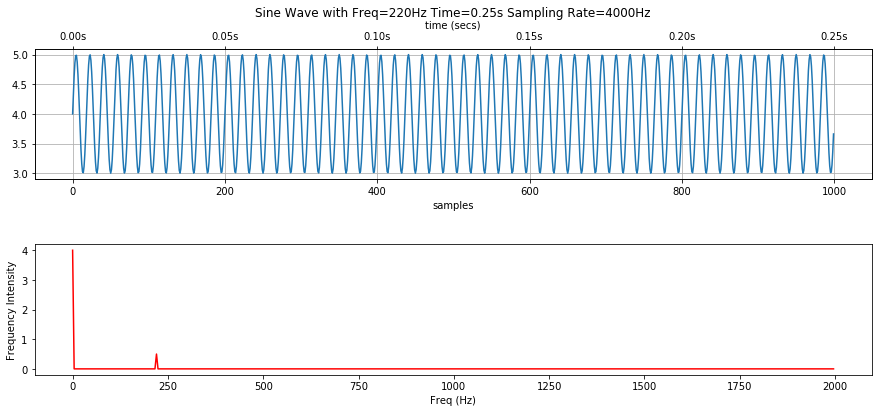

In [19]:
# Same thing as before but with a random offset to show the freq spike around 0
import random

total_time_in_secs = 0.25
sampling_rate = 4000
freq = 220 # in Hz - try changing this value to see how the spectral plot changes

time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.sin(2 * np.pi * freq * time) + random.randint(1,6)

fig, axes = plt.subplots(2, 1, figsize=(15,6))
fig.subplots_adjust(hspace=0.5)
plot_signal_to_axes(axes[0], s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate))

# analyze this signal
# the fft returns an array of n frequency bins representing energy from 0Hz to the sampling frequency
# due to the Nyquist theorem, the second half of the spectrum is the mirror image of the first half
# so we split the results in half (and just use the first half)
# see: http://web.science.mq.edu.au/~cassidy/comp449/html/ch06.html
# - https://docs.scipy.org/doc/numpy-1.10.0/reference/routines.fft.html#implementation-details
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

# plot the fft
print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[n//2])))
freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1
axes[1].plot(freqs, fft, 'r')
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq = freqs[idx]
print("Freq with max intensity {} Hz".format(freq))

# find the top N frequencies
# see: https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array?lq=1
top_n_freq = 3
abs_fft = np.abs(fft)
ind = np.argpartition(abs_fft, -top_n_freq)[-top_n_freq:] # from https://stackoverflow.com/a/23734295
#print(ind, ind[np.argsort(abs_fft[ind])])
#print(freqs[ind], abs_fft[ind])
ind_sorted_by_coef = ind[np.argsort(-abs_fft[ind])] # reverse sort indices
print(list(zip(freqs[ind_sorted_by_coef], abs_fft[ind_sorted_by_coef]))) # print top freq

ipd.Audio(s, rate=sampling_rate)

We have 2000 frequency bins of size 2.0Hz from 0.0 to 2000.0Hz
max freq: 200.0 with coef: 0.5000000000000014
[(200.0, 0.5000000000000014), (300.0, 0.5000000000000002), (400.0, 0.49999999999999933)]


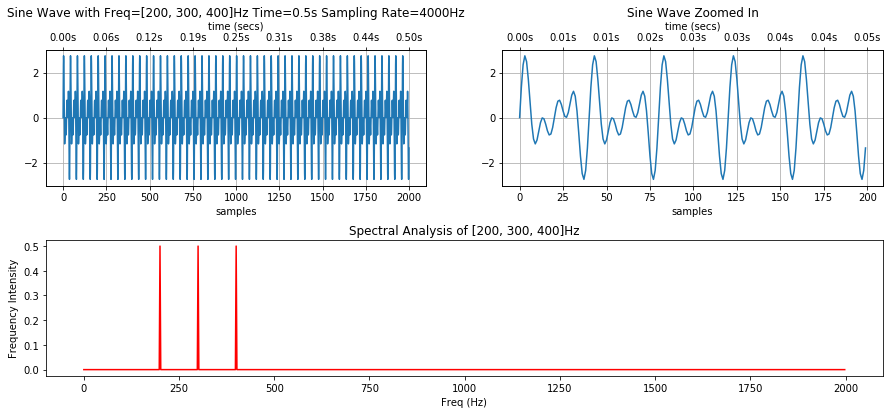

In [20]:
# now with multiple frequencies
total_time_in_secs = 0.5
sampling_rate = 4000
input_freqs = [200, 300, 400]
# freqs = [523.25, 659.25, 783.99] # c chord

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.zeros(len(time))
for freq in input_freqs:
    a = np.sin(2 * np.pi * freq * time)
    s += a

# analyze this signal
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[n//2])))

freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1

# create figure
plt.figure(figsize=(15, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.subplots_adjust(hspace=0.4)

plot_signal_to_axes(ax1, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(input_freqs, total_time_in_secs, sampling_rate))

plot_signal_to_axes(ax2, s[0: sampling_rate // 20], sampling_rate, 'Sine Wave Zoomed In')

ax3.plot(freqs, fft, 'r')
ax3.set_title('Spectral Analysis of {}Hz'.format(input_freqs))
ax3.set_xlabel('Freq (Hz)')
ax3.set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq_at_max_intensity = freqs[idx]
print("max freq: {} with coef: {}".format(freq_at_max_intensity, fft[idx]))

# find the top N frequencies
# see: https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array?lq=1
top_n_freq = len(input_freqs)
abs_fft = np.abs(fft)
ind = np.argpartition(abs_fft, -top_n_freq)[-top_n_freq:] # from https://stackoverflow.com/a/23734295
#print(ind, ind[np.argsort(abs_fft[ind])])
#print(freqs[ind], abs_fft[ind])
ind_sorted_by_coef = ind[np.argsort(-abs_fft[ind])] # reverse sort indices
print(list(zip(freqs[ind_sorted_by_coef], abs_fft[ind_sorted_by_coef]))) # print top freq

ipd.Audio(s, rate=sampling_rate)

We have 2000 frequency bins of size 2.0Hz from 0.0 to 2000.0Hz
max freq: 200.0 with coef: 0.5000000000000003
[(200.0, 0.5000000000000003), (300.0, 0.2500000000000001), (400.0, 0.12499999999999943), (650.0, 0.04999999999999989)]


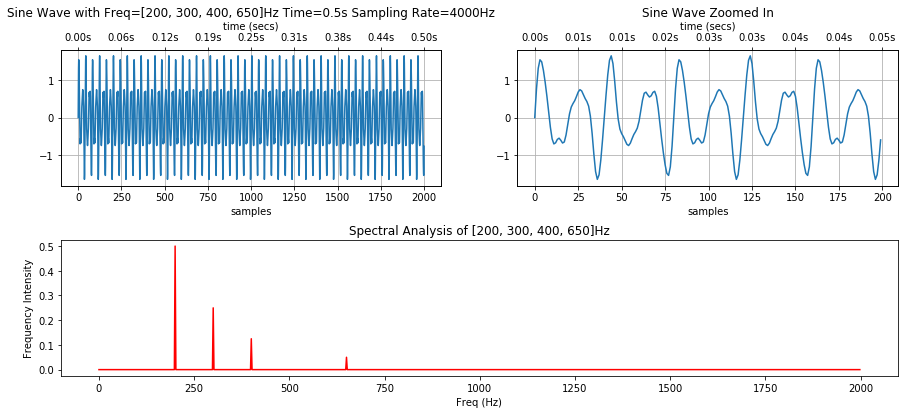

In [21]:
# now with multiple frequencies of different amounts
total_time_in_secs = 0.5
sampling_rate = 4000
input_freqs = [200, 300, 400, 650]
multiplier = [1, 0.5, 0.25, 0.1]
# freqs = [523.25, 659.25, 783.99] # c chord

# Create an array from 0 to total_time_in_secs * sampling_rate 
# But we need to divide each value in this array by our sampling_rate so that our time step (dt) is correct
time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
s = np.zeros(len(time))
i = 0
for freq in input_freqs:
    a = np.sin(2 * np.pi * freq * time) * multiplier[i]
    s += a
    i += 1

# analyze this signal
n = len(s)
fft = np.fft.fft(s)
freqs = np.fft.fftfreq(n)
freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

print("We have {} frequency bins of size {}Hz from {} to {}Hz".\
      format(len(freqs), (freqs[1]-freqs[0]), freqs[0], np.abs(freqs[n//2])))

freqs = freqs[range(n//2)] # one side freq range
fft = np.abs(fft)[range(n//2)] # one side freq range
fft = fft / n # normalize to values 0 - 1

# create figure
plt.figure(figsize=(15, 6))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.subplots_adjust(hspace=0.4)

plot_signal_to_axes(ax1, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(input_freqs, total_time_in_secs, sampling_rate))

plot_signal_to_axes(ax2, s[0: sampling_rate // 20], sampling_rate, 'Sine Wave Zoomed In')

ax3.plot(freqs, fft, 'r')
ax3.set_title('Spectral Analysis of {}Hz'.format(input_freqs))
ax3.set_xlabel('Freq (Hz)')
ax3.set_ylabel('Frequency Intensity')

# find the max frequency
idx = np.argmax(np.abs(fft))
freq_at_max_intensity = freqs[idx]
print("max freq: {} with coef: {}".format(freq_at_max_intensity, fft[idx]))

# find the top N frequencies
# see: https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array?lq=1
top_n_freq = len(input_freqs)
abs_fft = np.abs(fft)
ind = np.argpartition(abs_fft, -top_n_freq)[-top_n_freq:] # from https://stackoverflow.com/a/23734295
#print(ind, ind[np.argsort(abs_fft[ind])])
#print(freqs[ind], abs_fft[ind])
ind_sorted_by_coef = ind[np.argsort(-abs_fft[ind])] # reverse sort indices
print(list(zip(freqs[ind_sorted_by_coef], abs_fft[ind_sorted_by_coef]))) # print top freq

ipd.Audio(s, rate=sampling_rate)

In [22]:
# TODO: make a freq sweep animation
# See: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
# I show a freq sweep in class

In [23]:
# Concatate waves to make a scale and then analyze waveform using ffts
c_scale = [261.626, 293.665, 329.628, 349.228, 391.995, 440, 493.883, 523.251] # c scale starting with middle c at 261.626
total_time_per_note_in_secs = 1
sampling_rate = 11025

signal_combined = np.array([])
map_freq_to_signal = dict()
for freq_of_note in c_scale:
    # TODO: currently this concatenation is not smooth; need to align better based on period
    # You can hear the 'pop' of the sound when it transitions notes and can see it in the spectrogram below
    signal_for_note = create_sine_wave(freq_of_note, sampling_rate, total_time_per_note_in_secs)
    map_freq_to_signal[freq_of_note] = signal_for_note
    signal_combined = np.concatenate((signal_combined, signal_for_note))
    
# plot_multiple_freq(c_scale, signal_combined, map_freq_to_signal, sampling_rate)

ipd.Audio(signal_combined, rate=sampling_rate) 

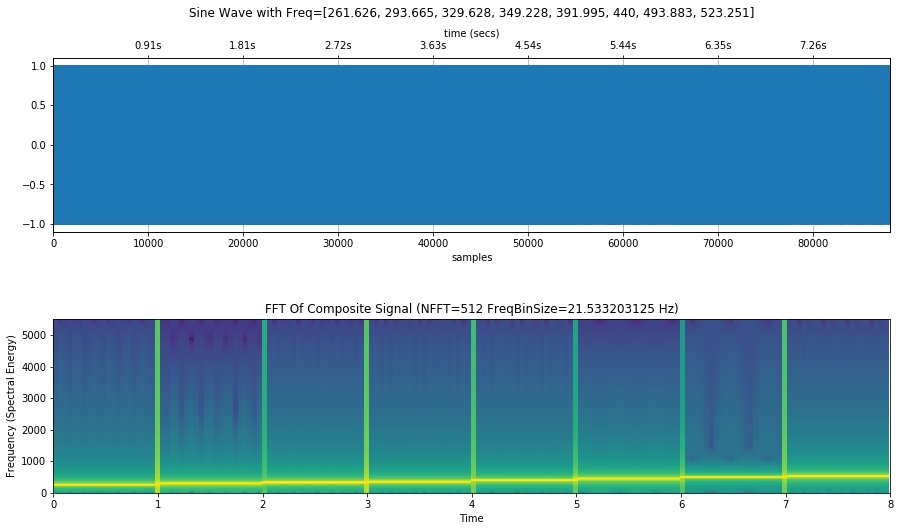

In [24]:
# Frequency analysis
# TODO: remove spectral spikes at freq boundaries

fig, axes = plt.subplots(2, 1, figsize=(15,8))
fig.subplots_adjust(hspace=0.5)
freqs = c_scale

axes[0].set_xlim(xmin=0,xmax=total_time_per_note_in_secs * len(freqs) * sampling_rate)
plot_signal_to_axes(axes[0], signal_combined, sampling_rate, 'Sine Wave with Freq={}'.format(freqs))

# NFFT is the num of points from sample used to calculate the FFT. Must be greater than 1/2 sampling rate
# noverlap is the num of overlapping points between NFFT windows

# You can calculate your frequency resolution (that is the size of each frequency bin)
# by FreqResolution = SamplingRate / FFTWindowSize
fft_window_size = 512
axes[1].specgram(signal_combined, NFFT=fft_window_size, Fs=sampling_rate, noverlap=0)
axes[1].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", 
            title='FFT Of Composite Signal (NFFT={} FreqBinSize={} Hz)'.
            format(fft_window_size, sampling_rate/fft_window_size))
# axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_xlim(xmin=0, xmax=total_time_per_note_in_secs * len(freqs))
print()

# Peak Detection

There are some great writeups about finding peaks using scipy [here](https://blog.ytotech.com/2015/11/01/findpeaks-in-python/) and [here](https://github.com/MonsieurV/py-findpeaks). While there are a number of different approaches/algorithms to try, the consensus seems to be that `scipy.signal.find_peaks` performs reliably well; however, this wasn't released until `scipy 1.1.0`. To determine what version you have installed, type `print(scipy.__version__)` in a cell (see below). If your version of scipy is less than 1.1.0, go into your Anaconda shell and type: `conda upgrade scipy`.

In [25]:
import scipy
print(scipy.__version__)

1.2.1


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05
 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75
 2.8  2.85 2.9  2.95 3.   3.05 3.1 ]
32 [1.6] [0.9995736]


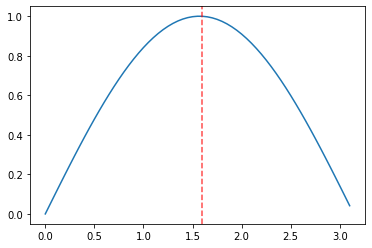

In [26]:
# See: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.find_peaks_cwt.html
# signal.find_peaks_cwt from https://academic.oup.com/bioinformatics/article/22/17/2059/274284
xs = np.arange(0, np.pi, 0.05)
print(xs)
data = np.sin(xs)
plt.plot(xs, data)
peak_idx = sp.signal.find_peaks_cwt(data, np.arange(1,10))
print(peak_idx[0], xs[peak_idx], data[peak_idx])
plt.axvline(x=xs[peak_idx], color='r', linestyle='--', alpha=0.7)

[  2  29  51  74  90 130 133 162 189] [10.69528849]


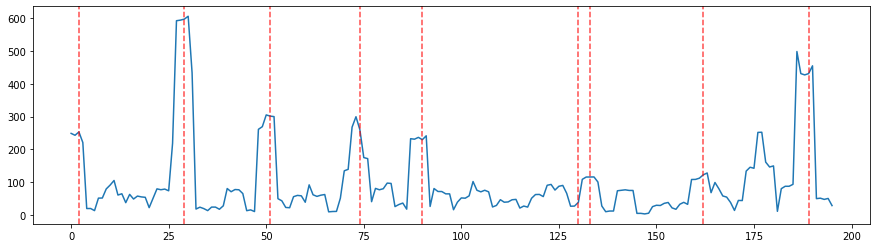

In [27]:
# Peak detection using find_peaks_cwt
mu, sigma = 3., 2.
length = 200
s = np.random.lognormal(mu, sigma, length)

filter_window_size = 5
s_smoothed = np.convolve(s, np.ones((filter_window_size,))/filter_window_size, mode='valid') 

plt.figure(figsize=(15, 4))
plt.plot(s_smoothed)

peak_indices = sp.signal.find_peaks_cwt(s_smoothed, np.arange(5,10))
print(peak_indices, s[peak_idx])

for peak_index in peak_indices:
    plt.axvline(x=peak_index, color='r', linestyle='--', alpha=0.7)

Detect peaks with minimum height and distance filters.
[ 2 22] [25 20]


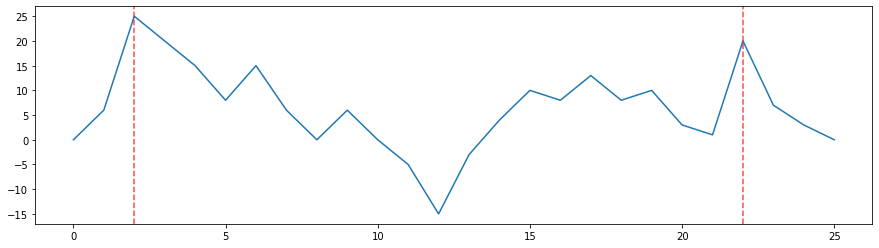

In [28]:
# Sample modified from https://github.com/MonsieurV/py-findpeaks#scipysignalfind_peaks
import numpy as np
import scipy.signal
s = np.array([0, 6, 25, 20, 15, 8, 15, 6, 0, 6, 0, -5, -15, -3, 4, 10, 8,
                   13, 8, 10, 3, 1, 20, 7, 3, 0])
print('Detect peaks with minimum height and distance filters.')

# change height to see different behavior
peak_indices, peak_properties = sp.signal.find_peaks(s, height=20, distance=2.1)
print(peak_indices, s[peak_indices])

plt.figure(figsize=(15, 4))
plt.plot(s)

for peak_index in peak_indices:
    plt.axvline(x=peak_index, color='r', linestyle='--', alpha=0.7)

In [29]:
s = np.array([0, 6, 25, 20, 15, 8, 15, 6, 0, 6, 0, -5, -15, -3, 4, 10, 8,
                   13, 8, 10, 3, 1, 20, 7, 3, 0])

# change height to see different 
peak_indices, peak_properties = sp.signal.find_peaks(s, height=20, distance=2.1)
print(peak_indices, s[peak_indices])

zero_crossings = calc_zero_crossings2(s, min_gap=1)
print(zero_crossings)

plt.figure(figsize=(15, 4))
plt.plot(s, marker='o')

for zero_index in zero_crossings:
    plt.plot(zero_index, s[zero_index], marker='X', markersize=8, color="orange")

for peak_index in peak_indices:
    plt.plot(peak_index, s[peak_index], marker='o', markersize=8, color="red")

plt.axhline(y=0, color='gray', alpha=0.5, linewidth=0.5)

[ 2 22] [25 20]


NameError: name 'calc_zero_crossings2' is not defined

In [ ]:
freq = 5
sampling_rate = 200
total_time_in_secs = 0.5
s = create_sine_wave(freq, sampling_rate, total_time_in_secs)
fig, ax = plt.subplots(figsize=(15,4))
plot_signal_to_axes(ax, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freq, total_time_in_secs, sampling_rate), marker='o')

# turn off grid lines to see easier
ax.grid(b=None)
ax.axhline(y=0, color='gray', alpha=0.5, linewidth=0.5) # plot origin

zero_crossings = calc_zero_crossings2(s)
print("{} zero crossings at: {}".format(len(zero_crossings), zero_crossings))

for zero_index in zero_crossings:
    ax.plot(zero_index, s[zero_index], marker='X', markersize=8, color="orange")

In [ ]:
import random

freqs = [5, 10, 25, 45, 60]
#freqs = random.sample(range(1, 100), 3)
sampling_rate = 900
total_time_in_secs = 0.5
s = None
for freq in freqs:
    signal_part = create_sine_wave(freq, sampling_rate, total_time_in_secs)
    if s is None:
        s = signal_part
    else:
        s += signal_part
    
fig, ax = plt.subplots(figsize=(15,4))
plot_signal_to_axes(ax, s, sampling_rate, 'Sine Wave with Freq={}Hz Time={}s Sampling Rate={}Hz'.
             format(freqs, total_time_in_secs, sampling_rate), marker='o')

# turn off grid lines to see easier
ax.grid(b=None)
ax.axhline(y=0, color='gray', alpha=0.5, linewidth=0.5) # plot origin

zero_crossings = calc_zero_crossings2(s, min_gap=50)
print("{} zero crossings at: {}".format(len(zero_crossings), zero_crossings))

for zero_index in zero_crossings:
    ax.plot(zero_index, s[zero_index], marker='X', markersize=8, color="orange")

# Sandbox
Everything below here is just a sandbox for me to play.

In [ ]:
# Sample from: https://musicinformationretrieval.com/ipython_audio.html
import IPython.display as ipd

sr = 512 # sample rate 22050
T = 5.0    # seconds
freq = 440
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
print(t)
x = 0.5*np.sin(2*np.pi*freq*t)                # pure sine wave at 440 Hz

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(x)
ax.set(xlabel='samples', title='Sine Wave with Freq={}'.format(freq))
ax.grid()

ipd.Audio(x, rate=sr) # load a NumPy array

# Outline
- Filtering
- FFT
  - Show how to calculate and use (maybe draw bar graph)
- Cross correlation
- Signal comparisons
  - show a few simple examples, including sin and cos (which are phase shifted)

## Ideas:
- Use audio as primary signal. You can play audio within Jupyter notebook https://musicinformationretrieval.com/ipython_audio.html
- Show effect of smoothing, etc.
- Show effects like reverb?

## Lecture Ideas for Future
- Go over cross-correlation algorithm (e.g., https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html)
- Go over convolution algorithm and how it can be used for filtering

# Sandbox: Cross Correlations with Non-Equal Signal Lengths
Warning: not all of this code works

In [ ]:
# Experimenting with cross correlation with different signal lengths
# TODO: what happens when index_shift is negative
from scipy import signal
from scipy.spatial import distance

#a = [8, 9, 10]
#a = np.array([10, 3, 2, 1, 0]) # a should always be shorter than b for this playground
a = np.array([1, 0, -1, -2])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])
#a = np.array([8, 9, 10])
#b = np.array([0, 0, 8, 9, 10, 0, 0, 0, 0, 0, 0])
a = np.array([3, 2, 1, 0, -1, -2])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

print(a)
print(b)

original_a_len = len(a)
a_padded = a
if len(a) < len(b):
    len_diff = len(b) - len(a)
    a_padded = np.pad(a, (0, len_diff), mode='constant', constant_values=0)
    #a_padded = np.pad(a, (0, len_diff), mode='mean')

print(a_padded)
print(b)

fig, axes = plt.subplots(7, figsize=(12, 16))
fig.subplots_adjust(hspace=0.5)

#euclid_distance_a_to_b = distance.euclidean(a, b)
corr_result_ab = signal.correlate(a_padded,b)
best_correlation_point = np.argmax(corr_result_ab)
index_shift = len(a_padded) - np.argmax(corr_result_ab) - 1

print(index_shift)

a_shifted = np.roll(a_padded, index_shift)

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

axes[1].plot(a_padded, alpha=0.7, label="a", marker="o")
axes[1].plot(b, alpha=0.7, label="b", marker="D")
axes[1].legend()
axes[1].set_title("Padded a, Original b")

axes[2].plot(corr_result_ab, alpha=0.7)
axes[2].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

axes[3].plot(a_shifted, alpha=0.7, label="a_shifted via rolling", marker="o")
axes[3].plot(b, alpha=0.7, label="b", marker="D")
axes[3].legend()

a_shifted_via_padding = np.pad(a_padded, (index_shift, 0), mode='constant', constant_values=0)

axes[4].plot(a_shifted_via_padding, alpha=0.7, label="a_shifted_via_padding", marker="o")
axes[4].plot(b, alpha=0.7, label="b", marker="D")
axes[4].legend()

#axes[5].plot([0,1,2,3], [None, None, 4, 5])

a_cutoff = a_shifted_via_padding[0:len(a_shifted_via_padding) - (len(a_padded) - len(a))]
a_cutoff = a_cutoff.tolist()
for i in range(0, index_shift):
    a_cutoff[i] = None
    
axes[5].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[5].plot(b, alpha=0.7, label="b", marker="D")
axes[5].legend()

# now cutoff b to be same length as a with best alignment
b_cutoff = b[index_shift:index_shift + len(a)]
a_cutoff = a_cutoff[index_shift:index_shift + len(a)]
axes[6].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[6].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[6].set_ylim(axes[0].get_ylim())
axes[6].legend()


#axes.set_title("Raw Graphs | Euclidean Distance From A to B = {:0.1f}".format(euclid_distance_a_to_b))
print()

In [ ]:
l = [0, 1, 2, 3, 4]
slicer = 2
print(l[slicer:len(l)])
print(len(l)-slicer)

In [ ]:
# Same as above but trying to fix for when index_shift is negative
from scipy import signal
from scipy.spatial import distance

a = [8, 9, 10]
#a = np.array([9, 9, 10])
#a = np.array([10, 3, 2, 1, 0]) # a should always be shorter than b for this playground
#a = np.array([0, 0, 0, 7, 8, 9, 10])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

a = np.array([3, 2, 1, 0, -1, -2])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

#a = np.array([9, 10, 10, 2, 1])
#b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

#a = np.array([8, 9, 10])
#b = np.array([0, 0, 8, 9, 10, 0, 0, 0, 0, 0, 0])

print(a)
print(b)

original_a_len = len(a)
a_padded = a
if len(a) < len(b):
    len_diff = len(b) - len(a)
    a_padded = np.pad(a, (0, len_diff), mode='constant', constant_values=0)
    #a_padded = np.pad(a, (0, len_diff), mode='mean')

print(a_padded)
print(b)

fig, axes = plt.subplots(7, figsize=(12, 16))
fig.subplots_adjust(hspace=0.5)

#euclid_distance_a_to_b = distance.euclidean(a, b)
corr_result_ab = signal.correlate(a_padded,b)
best_correlation_point = np.argmax(corr_result_ab)
index_shift = len(a_padded) - np.argmax(corr_result_ab) - 1
index_shift_abs = abs(index_shift)

print(index_shift)

a_shifted = np.roll(a_padded, index_shift)

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

axes[1].plot(a_padded, alpha=0.7, label="a", marker="o")
axes[1].plot(b, alpha=0.7, label="b", marker="D")
axes[1].legend()
axes[1].set_title("Padded a, Original b")

axes[2].plot(corr_result_ab, alpha=0.7)
axes[2].set_title("Correlation Between A and B (Best Correlation Index = {})".format(best_correlation_point))

axes[3].plot(a_shifted, alpha=0.7, label="a_shifted via rolling", marker="o")
axes[3].plot(b, alpha=0.7, label="b", marker="D")
axes[3].legend()

a_shifted = None
if index_shift >= 0:
    a_shifted = np.pad(a_padded, (index_shift, 0), mode='constant', constant_values=0)
else:
    a_shifted = a_padded[index_shift_abs:len(a_padded)]

axes[4].plot(a_shifted, alpha=0.7, label="a_shifted", marker="o")
axes[4].plot(b, alpha=0.7, label="b", marker="D")
axes[4].legend()

#axes[5].plot([0,1,2,3], [None, None, 4, 5])
a_cutoff = None
if index_shift >= 0:
    a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))] # cutoff the right side that we added on for padding
    a_cutoff = a_cutoff.tolist()
    for i in range(0, index_shift_abs):
        a_cutoff[i] = None
else:
    a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))]
 
axes[5].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[5].plot(b, alpha=0.7, label="b", marker="D")
axes[5].legend()

# now cutoff b to be same length as a with best alignment
b_cutoff = None
if index_shift >= 0:
    b_cutoff = b[index_shift_abs:index_shift_abs + len(a)]
    print(len(a), len(b_cutoff))
    length = min(len(a), len(b_cutoff))
    a_cutoff = a_cutoff[index_shift_abs:index_shift_abs + length]
else:
    b_cutoff = b[0:len(a_cutoff)]
    
axes[6].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[6].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[6].set_ylim(axes[0].get_ylim())
axes[6].legend()


#axes.set_title("Raw Graphs | Euclidean Distance From A to B = {:0.1f}".format(euclid_distance_a_to_b))
print()

In [ ]:
# Helper function to align signals. 
# Returns a shifted signal of signal 'a' based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = sp.signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of signal 'a' based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = sp.signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr) - 1
    index_shift_abs = abs(index_shift )

    a_shifted_cutoff = None
    if index_shift < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs, 0), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# TODO: this method has a bug
def get_aligned_signals_ablate(a, b):
    if len(a) > len(b):
        a_cutoff, b_cutoff = get_aligned_signals_ablate(b, a)
        return (b_cutoff, a_cutoff)
    
    original_a_len = len(a)
    a_padded = a
    
    if len(a) < len(b): # this should always be true unless a == b
        len_diff = len(b) - len(a)
        a_padded = np.pad(a, (0, len_diff), mode='constant', constant_values=0)
        #a_padded = np.pad(a, (0, len_diff), mode='mean') # doesn't work with 'mean'
        
    corr_result_ab = signal.correlate(a_padded,b)
    best_correlation_point = np.argmax(corr_result_ab)
    
    index_shift = len(a_padded) - np.argmax(corr_result_ab) - 1
    index_shift_abs = abs(index_shift)
    print("best_correlation_point", best_correlation_point, "index_shift", index_shift)
    
    if index_shift >= 0:
        a_shifted = np.pad(a_padded, (index_shift, 0), mode='constant', constant_values=0) # right shift, pad with 0
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))]
        b_cutoff = b[index_shift:index_shift + len(a)]
        length = min(len(a), len(b_cutoff))
        a_cutoff = a_cutoff[index_shift:index_shift + length]
    else:
        a_shifted = a_padded[index_shift_abs:len(a_padded)] # left shift via ablation
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))] # cut off remaining right side
        b_cutoff = b[0:len(a_cutoff)]
        
    if len(a_cutoff) != len(b_cutoff):
        print("uh oh, len(a_cutoff) != len(b_cutoff)", len(a_cutoff), len(b_cutoff))
    
    return (a_cutoff, b_cutoff)

    

In [ ]:
from scipy import signal
from scipy.spatial import distance

#a = [8, 9, 10]
#a = np.array([8, 10, 10, 2]) # a should always be shorter than b for this playground

# a = np.array([10, 3, 2, 1])
# b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])

a = np.array([3, 2, 1, 0, -1, -2])
b = np.array([5, 7, 8, 9, 10, 3, 2, 1, 0, -1, -2])
#b = np.array([0, 0, 8, 9, 10, 0, 0, 0, 0, 0, 0])
fig, axes = plt.subplots(2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)
axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

a_cutoff, b_cutoff = get_aligned_signals_ablate(a,b)
axes[1].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[1].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[1].legend()
axes[1].set_title("Aligned and Cutoff a, b")



In [ ]:
a = [-15.714632463246165, -19.265879387938607, -22.473233123312106, -25.336693669366674, -27.556261026102312, -29.83193519351902, -30.7930033003297, -31.554071407140384, -31.51513951395107, -31.37620762076175, -31.337275727572433, -31.19834383438311, -31.5594119411938, -32.52048004800449, -34.08154815481518, -35.64261626162587, -36.50368436843656, -36.66475247524724, -36.42582058205792, -35.686888688868606, -34.747956795679286, -34.10902490248997, -33.37009300930066, -30.131161116111343, -23.492229222922028, -10.853297329732708, 8.785634563456608, 33.92456645664592, 61.76349834983523, 92.40243024302455, 122.94136213621388, 150.7802940294032, 183.2192259225925, 207.15815781578186, 207.19708970897113, 183.83602160216046, 149.87495349534976, 118.61388538853906, 92.45281728172839, 63.591749174917695, 32.630681068106995, 3.2696129612963203, -29.29145514551437, -54.95252325232505, -60.51359135913574, -50.274659465946414, -37.9357275727571, -33.696795679567785, -36.35786378637847, -38.91893189318915, -38.77999999999983, -37.341068106810525, -37.102136213621215, -37.4632043204319, -37.72427242724258, -36.38534053405326, -33.74640864086395, -31.10747674767463, -29.868544854485318, -28.729612961296002, -27.990681068106692, -27.251749174917375, -25.91281728172806, -24.173885388538743, -22.134953495349432, -20.59602160216012, -19.25708970897081, -18.118157815781494, -16.479225922592175, -14.940294029402855, -13.401362136213539, -11.862430243024226, -9.923498349834915, -9.384566456645597, -8.745634563456282, -8.306702670266965, -7.467770777077648, -4.7288388838883355, -2.4899069906990237, -1.2509750975097063, -0.2120432043203892, 0.826888688868928, 0.9658205820582453, 2.1047524752475564, 3.143684368436868, 4.68261626162618, 6.021548154815497, 5.160480048004814, 4.399411941194131, 4.538343834383443, 4.477275727572754, 4.416207620762072, 4.155139513951388, 3.3940714071407054, 3.833003300330023, 3.3719351935193402, 2.892261026102597, 2.668693669366923, 2.601233123312318, 2.289879387938783]
b = [-24.717479539556905, -29.161361368021883, -33.33870517000472, -37.649510945505426, -41.893778694523995, -45.77150841706043, -44.4061281522391, -42.54074788741775, -39.975367622596416, -36.30998735777508, -30.544607092953736, -24.079226828132395, -17.113846563311057, -9.848466298489713, -2.1830860336683706, 5.18229423115297, 12.14767449597432, 18.513054760795676, 23.67843502561702, 25.943815290438373, 25.009195555259723, 23.674575820081078, 22.63995608490243, 22.905336349723783, 23.270716614545133, 22.73609687936648, 21.901477144187837, 20.166857409009175, 17.632237673830517, 15.79761793865185, 14.962998203473193, 13.528378468294536, 10.693758733115875, 5.959138997937215, 0.4245192627585552, -4.410100472420106, -8.844720207598765, -11.079339942777414, -11.513959677956063, -11.74857941313471, -10.783199148313361, -10.717818883492008, -11.052438618670656, -10.687058353849306, -9.821678089027955, -7.756297824206603, -3.7909175593852527, -1.025537294563913, 0.9398429702574285, 4.005223235078768, 6.670603499900108, 11.035983764721449, 17.00136402954279, 23.566744294364128, 30.23212455918547, 34.99750482400681, 36.16288508882815, 37.0282653536495, 38.99364561847085, 40.6590258832922, 41.62440614811355, 41.8897864129349, 41.65516667775626, 41.02054694257761, 39.785927207398956, 38.15130747222031, 35.91668773704166, 32.282068001863024, 28.247448266684355, 23.312828531505694, 18.378208796327034, 14.143589061148372, 10.408969325969712, 7.074349590791054, 4.6397298556123925, 3.405110120433733, 3.370490385255073, 3.535870650076413, 2.401250914897764, 1.866631179719116, 1.9320114445404655, 1.897391709361818, 1.8627719741831696, 0.7281522390045208, -1.706467496174128, -4.741087231352777, -7.075706966531425, -7.910326701710086, -7.4449464368887455, -6.579566172067405, -6.314185907246065, -7.3488056424247254, -9.583425377603385, -11.718045112782045, -12.952664847960705, -13.687284583139368, -13.821904318318026, -14.056524053496675, -14.891143788675324, -16.22576352385397, -17.66038325903262, -18.69500299421127, -19.42962272938992, -19.96424246456857, -20.598862199747217, -21.133481934925864, -21.86810167010451, -22.40272140528316, -22.837341140461806, -20.81418590724602, -18.557568700512366, -16.167489520260848, -13.743948366491464]

fig, axes = plt.subplots(2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)
axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

a_cutoff, b_cutoff = get_aligned_signals_ablate(a,b)
axes[1].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[1].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[1].legend()
axes[1].set_title("Aligned and Cutoff a, b")


In [ ]:
# Create and plot a simple sine and cos wave
total_time_in_secs = 1
sampling_rate = 200
freq = 5

a = create_sine_wave(freq, sampling_rate, total_time_in_secs)
b = create_cos_wave(freq, sampling_rate, total_time_in_secs)
b = b[0:50]

fig, axes = plt.subplots(2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)
axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title("Original a, b")

a_cutoff, b_cutoff = get_aligned_signals_ablate(a,b)
axes[1].plot(a_cutoff, alpha=0.7, label="a_cutoff", marker="o")
axes[1].plot(b_cutoff, alpha=0.7, label="b_cutoff", marker="D")
axes[1].legend()
axes[1].set_title("Aligned and Cutoff a, b")
